## Методы машинного обучения. Лабораторная работа №4

# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.
## Цель лабораторной работы:
изучение сложных способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

## Задание:

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.
5. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.
7. Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
8. Постройте кривые обучения и валидации.



Постановка задачи

Пусть дана обучающая выборка:

Xtrain - матрица объекты-признаки (feature matrix); если необходимо указать конкретный элемент матрицы, то будем использовать обозначение Xtrain(o,f), где o - индекс объекта (соответствуют строке матрицы), а f - индекс признака (соответствуют столбцу матрицы);
Ytrain - вектор целевого признака; если необходимо указать конкретный элемент вектора, то будем использовать обозначение Ytrain(o), где o - индекс объекта (соответствуют индексу вектора);
можно рассматривать Xtrain|Ytrain как блочную матрицу, количество строк в матрице Xtrain соответствует размерности вектора Ytrain.
На основании алгоритма Alg, который использует гиперпараметры H, для обучающей выборки строится модель M:Xtrain→Ytrain, которая устанавливает соответствие между Xtrain и Ytrain: M=Alg.fit(Xtrain,Ytrain,H).

Также дана тестовая выборка Xtest для которой на основании найденной модели M необходимо найти (предсказать) значения Ytest=Alg.predict(M,Xtest).

В случае k-NN:

в качестве алгоритма Alg используется метод k-ближайших соседей;
количество ближайших соседей k является гиперпараметром алгоритма, то есть до начала работы алгоритма необходимо задать количество ближайших соседей K, значения Ytrain которых будут использованы для нахождения Ytest.

1. Подготовка данных; датасет -
https://www.kaggle.com/ronitf/heart-disease-uci/version/1
1. age;---возраст;
2. sex;---пол;
3. chest pain type (4 values);---Тип боли;
4. resting blood pressure;---Кровяное давление в покое;
5. serum cholestoral in mg/dl;---Холестерин;
6. fasting blood sugar > 120 mg/dl;---Сахар в крови;
7. resting electrocardiographic results (values 0,1,2);---Электрокардиография в покое;
8. maximum heart rate achieved;---Максимальный сердечный ритм;
9. exercise induced angina;---Стенокардия вызванная физической нагрузкой;
10. oldpeak = ST depression induced by exercise relative to rest;---депрессия вызванная физ упражнениями;
11. the slope of the peak exercise ST segment;---Наклон пика упражнений;
12. number of major vessels (0-3) colored by flourosopy;---Кол-во крупных сосоудов по цвету
thal: 3 = normal; 6 = fixed defect; 7 = reversable defect; 

In [203]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [204]:
pd.options.mode.chained_assignment = None

In [205]:
data = pd.read_csv('C:/Users/VTsapiy/Desktop/data/heart.csv')

Данный датасет содержит информацию о вине, стране происхождения, оценке и т.д.
Рассмотрим данные о стране происхождения, сорте винограда, виноднльне, оценке вина.

In [206]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


В датасете отсутствуют пустые значения.

In [207]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

В датасете отсутствуют пустые значения

In [208]:
data.shape

(303, 14)

In [209]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [210]:
X = data.drop('target',axis = 1).values
y = data['target'].values

### Разделение датасета на тестовую и тренировочную выборку

In [211]:
from sklearn.model_selection import train_test_split
# Функция train_test_split разделил исходную выборку таким образом, 
#чтобы в обучающей и тестовой частях сохранились пропорции классов.
heart_X_train, heart_X_test, heart_y_train, heart_y_test = train_test_split(
    X, y, test_size=0.35, random_state=1)

In [212]:
print('heart_X_train: {}  heart_y_train: {}'.format(heart_X_train.shape, heart_y_train.shape))

heart_X_train: (196, 13)  heart_y_train: (196,)


In [213]:
print('heart_X_test: {}  heart_y_test: {}'.format(heart_X_test.shape, heart_y_test.shape))

heart_X_test: (107, 13)  heart_y_test: (107,)


In [214]:
np.unique(heart_y_train)

array([0, 1], dtype=int64)

In [215]:
np.unique(heart_y_test)

array([0, 1], dtype=int64)

## Обучение модели ближайших соседей для произвольно заданного гиперпараметра K. 
#### Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.

In [216]:
# Настроим массивы для точности обучения
neighbors = np.arange(1,14)
len(neighbors)

13

### Обучение при различном количестве соседей

In [217]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_curve,confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score

In [218]:
# Вернуть новый массив заданной формы и типа без инициализации записей.
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Настройка классификатора Knn с K соседями
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Обучить модель
    knn.fit(heart_X_train, heart_y_train)
    
    # Вычислить точность на тренировочном наборе
    train_accuracy[i] = knn.score(heart_X_train, heart_y_train)
    
    # Вычислить точность на тестовом наборе
    test_accuracy[i] = knn.score(heart_X_test, heart_y_test)

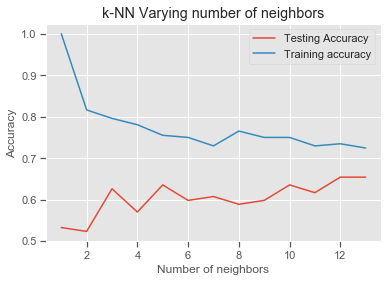

In [219]:
# Построить набор
plt.style.use('ggplot')

plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

KNeighborsClassifier

In [220]:
knn = KNeighborsClassifier(n_neighbors=12)

#Fit the model
knn.fit(heart_X_train,heart_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                     weights='uniform')

In [221]:
knn.score(heart_X_test,heart_y_test)

0.6542056074766355

In [222]:
from sklearn.metrics import classification_report

y_pred = knn.predict(heart_X_test)
print(classification_report(heart_y_test,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.66      0.64        50
           1       0.69      0.65      0.67        57

    accuracy                           0.65       107
   macro avg       0.65      0.65      0.65       107
weighted avg       0.66      0.65      0.65       107



Выведем точность

In [223]:
from sklearn.metrics import roc_curve,confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score

In [224]:
cl1_1 = KNeighborsClassifier(n_neighbors=12)
cl1_1.fit(heart_X_train, heart_y_train)
target1_1 = cl1_1.predict(heart_X_test)
accuracy_score(heart_y_test, target1_1)

0.6542056074766355

Построим матрицу

In [225]:
y_pred = knn.predict(heart_X_test)
confusion_matrix(heart_y_test,y_pred)
pd.crosstab(heart_y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,33,17,50
1,20,37,57
All,53,54,107


ROC(Reciever Operating Charecteristic)

In [226]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

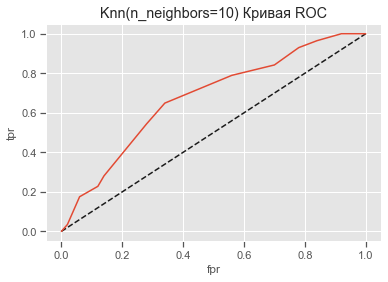

In [227]:
y_pred_proba = knn.predict_proba(heart_X_test)[:,1]
fpr, tpr, thresholds = roc_curve(heart_y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=10) Кривая ROC')
plt.show()

In [228]:
y_pred_proba

array([0.5       , 0.66666667, 0.41666667, 0.66666667, 0.16666667,
       0.5       , 0.16666667, 0.58333333, 0.5       , 0.66666667,
       0.66666667, 0.5       , 0.58333333, 0.25      , 0.66666667,
       0.91666667, 0.91666667, 0.41666667, 0.91666667, 0.41666667,
       0.5       , 0.41666667, 0.41666667, 0.5       , 0.66666667,
       0.83333333, 0.5       , 1.        , 0.41666667, 0.66666667,
       0.91666667, 0.83333333, 0.66666667, 0.58333333, 0.41666667,
       1.        , 0.33333333, 0.66666667, 0.83333333, 0.25      ,
       0.66666667, 0.33333333, 0.66666667, 0.25      , 0.66666667,
       0.66666667, 0.5       , 0.75      , 0.91666667, 0.16666667,
       0.83333333, 0.83333333, 0.33333333, 0.33333333, 0.75      ,
       0.66666667, 0.66666667, 0.58333333, 1.        , 0.08333333,
       0.33333333, 0.91666667, 0.58333333, 0.66666667, 0.83333333,
       0.58333333, 0.5       , 0.75      , 0.16666667, 0.33333333,
       0.33333333, 0.75      , 0.08333333, 0.66666667, 0.16666

In [229]:
roc_auc_score(heart_y_test,y_pred_proba)

0.6740350877192982

Кросс-валидация

In [230]:
import warnings
warnings.filterwarnings('ignore')

param_grid = {'n_neighbors':np.arange(1,14)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [231]:
knn_cv.best_score_

0.6601092896174864

In [232]:
knn_cv.best_params_

{'n_neighbors': 12}

Каждой стратегии в scikit-learn ставится в соответствии специальный класс-итератор, который может быть указан в качестве параметра cv функций cross_val_score и cross_validate. Работает в соответствии с кросс-валидацией

In [233]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=12), 
                         X, y, 
                         cv=KFold(n_splits=10))

In [234]:
scores #точность для 10 k-fold

array([0.5483871 , 0.61290323, 0.64516129, 0.6       , 0.5       ,
       0.66666667, 0.4       , 0.63333333, 0.66666667, 0.56666667])

In [235]:
np.mean(scores) #Усредненное значение

0.5839784946236558

In [236]:
warnings.filterwarnings('ignore')
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

scores = cross_validate(KNeighborsClassifier(n_neighbors=4), 
                        X, y, scoring=scoring, 
                        cv=KFold(n_splits=5), return_train_score=True)
scores

{'fit_time': array([0.00250149, 0.00150084, 0.00150108, 0.00150037, 0.00150084]),
 'score_time': array([0.01600957, 0.01451111, 0.00900769, 0.00800586, 0.00800657]),
 'test_precision': array([1.        , 1.        , 0.74327869, 1.        , 1.        ]),
 'train_precision': array([0.79272947, 0.78911533, 0.76025871, 0.79711127, 0.80984164]),
 'test_recall': array([0.36065574, 0.49180328, 0.60655738, 0.45      , 0.6       ]),
 'train_recall': array([0.7768595 , 0.76859504, 0.74380165, 0.78600823, 0.79423868]),
 'test_f1': array([0.53012048, 0.65934066, 0.62005786, 0.62068966, 0.75      ]),
 'train_f1': array([0.76729516, 0.75673435, 0.74007707, 0.78961321, 0.79856665])}

Leave One Out (LOO)
В тестовую выборку помещается единственный элемент (One Out). Количество фолдов в этом случае определяется автоматически и равняется количеству элементов. Данный метод более ресурсоемкий чем KFold. Существует правило, что вместо Leave One Out лучше использовать KFold на 5 или 10 фолдов.

In [237]:
# Эквивалент KFold(n_splits=n)
loo = LeaveOneOut()
loo.get_n_splits(X)

for train_index, test_index in loo.split(X):
   heart_X_train, heart_X_test = X[train_index], X[test_index]
   heart_y_train, heart_y_test = y[train_index], y[test_index]

Repeated K-Fold

In [238]:
scores2 = cross_val_score(KNeighborsClassifier(n_neighbors=12), 
                         X, y, 
                         cv=RepeatedKFold(n_splits=5, n_repeats=2))

In [239]:
scores2

array([0.57377049, 0.63934426, 0.63934426, 0.61666667, 0.66666667,
       0.67213115, 0.67213115, 0.62295082, 0.66666667, 0.68333333])

Обучение с оптимальным K

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

In [241]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.6542056074766355

Построение кривых обучения

In [242]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\users\\vtsapiy\\appdata\\local\\programs\\python\\python37-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

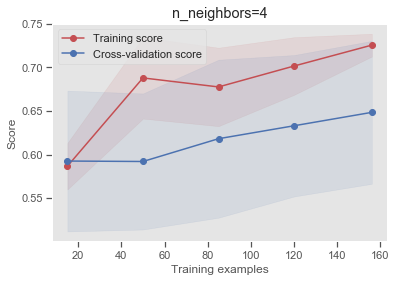

In [243]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=12), 'n_neighbors=4', 
                    X_train, y_train, cv=5)

Построение кривой валидации

In [244]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.0)
    lw = 4
    plt.plot(param_range, train_scores_mean, label="Данные обучения",
                 color="darkred", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkred", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Данные кросс-валидации",
                 color="blue", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="red", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\users\\vtsapiy\\appdata\\local\\programs\\python\\python37-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

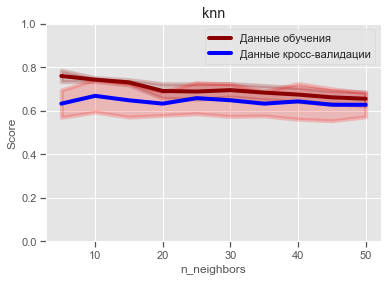

In [245]:
n_range = np.array(range(5,55,5))
plot_validation_curve(KNeighborsClassifier(n_neighbors=4), 'knn', 
                      X_train, y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=5, scoring="accuracy")